In [7]:
import xarray as xr
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import root_mean_squared_error
from scipy import stats

import os

import shap
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import numpy as np
from scipy import stats

script_dir = os.getcwd()

In [ ]:
print(script_dir)

# Load in OMG plume ensemble results

In [9]:
ds = xr.open_dataset(f'../../data_for_repo_aug2025/OMG_plume_ensemble_results_reduced_2.nc')
print(ds)
print(f'\nNumber of profiles: {len(ds.profile)}')

<xarray.Dataset> Size: 170MB
Dimensions:               (profile: 4240, depth: 1000)
Dimensions without coordinates: profile, depth
Data variables:
    temperature_profile   (profile, depth) float64 34MB ...
    depth_profile         (profile, depth) float64 34MB ...
    ctd_temp_profile      (profile, depth) float64 34MB ...
    ctd_density_profile   (profile, depth) float64 34MB ...
    ctd_salinity_profile  (profile, depth) float64 34MB ...
    Q0                    (profile) float64 34kB ...
    alpha                 (profile) float64 34kB ...
    z_max                 (profile) float64 34kB ...

Number of profiles: 4240


## Add surface flags, top, middle, bottom third temp and stratification metrics to each profile

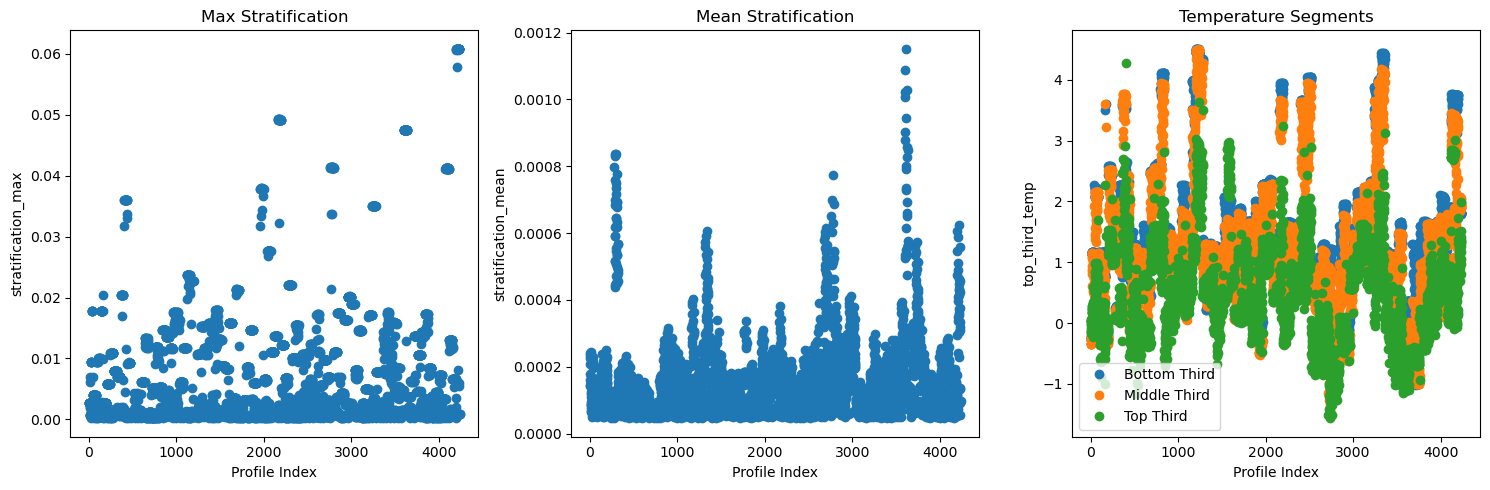

In [10]:
def add_surface_flag(ds):
    # Check if any depth_profile value is between 0 and -2 meters for each profile
    surface_flag = ((ds.depth_profile >= -2) & (ds.depth_profile <= 0)).any(dim='depth')
    ds['surfaced'] = surface_flag
    return ds

# Calculate the mean temperature for each profile segment
def calculate_temperature_segments(ds):
    n_layers = ds.depth.size
    thirds = n_layers // 3
    
    # Bottom third
    ds['bottom_third_temp'] = ds.ctd_temp_profile.isel(depth=slice(0, thirds)).mean(dim='depth')
    # Middle third
    ds['middle_third_temp'] = ds.ctd_temp_profile.isel(depth=slice(thirds, 2*thirds)).mean(dim='depth')
    # Top third
    ds['top_third_temp'] = ds.ctd_temp_profile.isel(depth=slice(2*thirds, n_layers)).mean(dim='depth')

    # Average of the whole profile
    ds['mean_temp'] = ds.ctd_temp_profile.mean(dim='depth')
    return ds


# # Calculate stratification using Brunt-Vaisala frequency 
def calculate_stratification(ds):
    grav = 9.81  
    dens0 = ds.ctd_density_profile.isel(depth=0)  # Take the last depth value as reference density
    drho = ds.ctd_density_profile.diff(dim='depth')
    dz = ds.depth_profile.diff(dim='depth')

    dz = dz.where(dz != 0)

    N2 = (-grav / dens0) * (drho / dz)

    ds['stratification_max'] = N2.max(dim='depth')
    ds['stratification_mean'] = N2.mean(dim='depth')
    
    return ds

# Apply all the functions
ds = add_surface_flag(ds)
ds = calculate_temperature_segments(ds)
ds = calculate_stratification(ds)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ds.stratification_max.plot(ax=ax[0], marker='o', linestyle='None')
ds.stratification_mean.plot(ax=ax[1], marker='o', linestyle='None')
ds.bottom_third_temp.plot(ax=ax[2], marker='o', linestyle='None')
ds.middle_third_temp.plot(ax=ax[2], marker='o', linestyle='None')
ds.top_third_temp.plot(ax=ax[2], marker='o', linestyle='None')
ax[0].set_title('Max Stratification')
ax[1].set_title('Mean Stratification')
ax[2].set_title('Temperature Segments')
ax[2].legend(['Bottom Third', 'Middle Third', 'Top Third'])
ax[0].set_xlabel('Profile Index')
ax[1].set_xlabel('Profile Index')
ax[2].set_xlabel('Profile Index')
plt.tight_layout()
plt.show()

## Plot histograms of PST and scatter graph

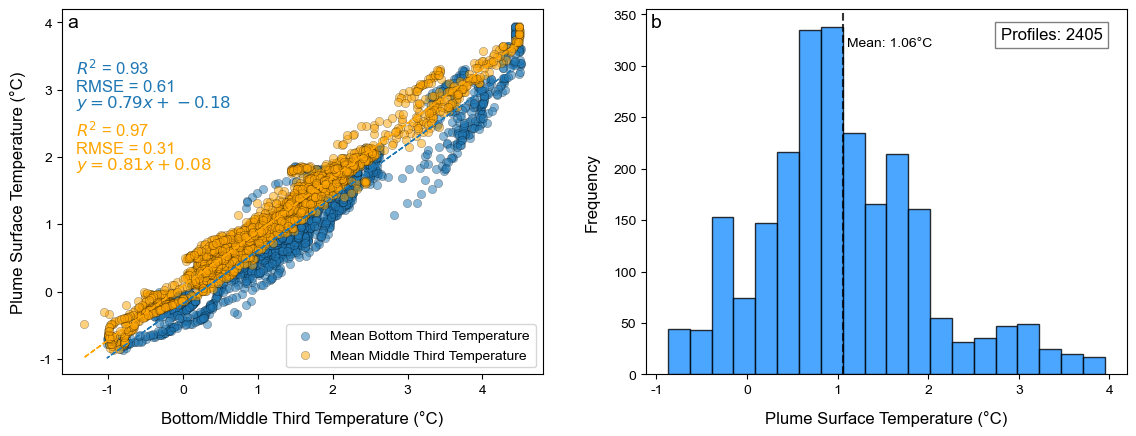

Mean: 1.06°C
Median: 0.96°C
Std: 0.91°C
Min: -0.87°C
Max: 3.95°C
Range: 4.82°C


In [11]:
# Filter surfaced plumes
ds_surface = ds.where(ds.surfaced, drop=True)

# drop NaN values in bottom third temperature, middle third temperature, and surface temperature
ds_surface = ds_surface.dropna(dim='profile', subset=['bottom_third_temp', 'middle_third_temp', 'temperature_profile'])

######## creating figure with scatter plot and histogram ########
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.style.use('default')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False # stop warnings

# Data for scatter
bottom_temp = ds_surface.bottom_third_temp.values.flatten()
middle_temp = ds_surface.middle_third_temp.values.flatten()
surface_temp = ds_surface['temperature_profile'].isel(depth=-1).values.flatten()

sc1 = ax1.scatter(bottom_temp, surface_temp, c='#1f77b4', alpha=0.5, edgecolor='k', linewidth=0.3, label='Mean Bottom Third Temperature')
sc2 = ax1.scatter(middle_temp, surface_temp, c='orange', alpha=0.5, edgecolor='k', linewidth=0.3, label='Mean Middle Third Temperature')


s_bottom = stats.linregress(bottom_temp, surface_temp)
r2_bottom = s_bottom.rvalue**2
rmse_bottom = root_mean_squared_error(surface_temp, bottom_temp)
ax1.text(0.03, 0.87, f'$R^2$ = {r2_bottom:.2f}\nRMSE = {rmse_bottom:.2f}', transform=ax1.transAxes,
                 fontsize=12, verticalalignment='top', color='#1f77b4')
ax1.plot(bottom_temp, s_bottom.intercept + s_bottom.slope * bottom_temp,
         color='#1f77b4', linewidth=1, linestyle='--')
# add text box of line equation
ax1.text(0.03, 0.77, f'$y = {s_bottom.slope:.2f}x + {s_bottom.intercept:.2f}$', transform=ax1.transAxes,
                 fontsize=12, verticalalignment='top', color='#1f77b4')

# Stats for middle third
s_middle = stats.linregress(middle_temp, surface_temp)
r2_middle = s_middle.rvalue**2
rmse_middle = root_mean_squared_error(surface_temp, middle_temp)
ax1.text(0.03, 0.7, f'$R^2$ = {r2_middle:.2f}\nRMSE = {rmse_middle:.2f}', transform=ax1.transAxes,
                 fontsize=12, verticalalignment='top', color='orange')
ax1.plot(middle_temp, s_middle.intercept + s_middle.slope * middle_temp,
         color='orange', linewidth=1, linestyle='--')
# add text box of line equation
ax1.text(0.03, 0.6, f'$y = {s_middle.slope:.2f}x + {s_middle.intercept:.2f}$', transform=ax1.transAxes,
                 fontsize=12, verticalalignment='top', color='orange')

ax1.set_xlabel('Bottom/Middle Third Temperature (°C)', fontsize=12, labelpad=10)
ax1.set_ylabel('Plume Surface Temperature (°C)', fontsize=12, labelpad=10)
ax1.legend()
ax1.text(0.01, 0.99, 'a', transform=ax1.transAxes, fontsize=14, verticalalignment='top')

# Histogram
temp_data = surface_temp
n, bins, patches = ax2.hist(temp_data, bins=20, color='dodgerblue',
                                                   alpha=0.8, edgecolor='k')

ax2.set_xlabel('Plume Surface Temperature (°C)', fontsize=12, labelpad=10)
ax2.set_ylabel('Frequency', fontsize=12, labelpad=10)

num_profiles = len(temp_data)
ax2.text(0.95, 0.95, f'Profiles: {num_profiles}', transform=ax2.transAxes,
                fontsize=12, verticalalignment='top', horizontalalignment='right', 
                bbox=dict(facecolor='white', alpha=0.5))

# Add mean and median lines
mean_temp = np.mean(temp_data)
median_temp = np.median(temp_data)
ax2.axvline(mean_temp, color='k', linestyle='--', linewidth=1.5, alpha=0.8)
ax2.text(mean_temp+0.05, ax2.get_ylim()[1]*0.9, f'Mean: {mean_temp:.2f}°C',
                fontsize=10)

ax2.text(0.01, 0.99, 'b', transform=ax2.transAxes,
                fontsize=14, verticalalignment='top')

plt.tight_layout(pad=3.0)
plt.savefig('plume_temperature_analysis2.png', dpi=300, bbox_inches='tight')
plt.show()

# print plume surface temperature stats
std_temp = np.std(temp_data)
min_temp = np.min(temp_data)
max_temp = np.max(temp_data)
print(f'Mean: {mean_temp:.2f}°C')
print(f'Median: {median_temp:.2f}°C')
print(f'Std: {std_temp:.2f}°C')
print(f'Min: {min_temp:.2f}°C')
print(f'Max: {max_temp:.2f}°C')
print(f'Range: {max_temp - min_temp:.2f}°C')


# Random forest sensitivy analysis for SURFACING

prepping data
splitting data
training model


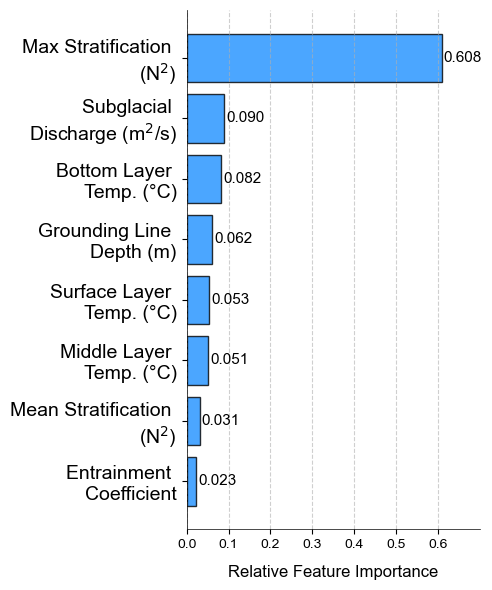

In [ ]:
def prepare_data(ds):
    """Prepare data for Random Forest model."""

    X = ds[['Q0', 'alpha', 'z_max', 'bottom_third_temp', 'middle_third_temp', 'top_third_temp', 'stratification_mean', 'stratification_max']].to_array().T
    y_surface = ds['surfaced'].values

    return X, y_surface

print('prepping data')
X, y_surface = prepare_data(ds)

# Split data for the surface model
print('splitting data')
X_train, X_test, y_train_surface, y_test_surface = train_test_split(X, y_surface, test_size=0.2, random_state=0)

# Train Random Forest for surfacing
print('training model')
rf_surface = RandomForestRegressor(n_estimators=100, random_state=0)
rf_surface.fit(X_train, y_train_surface)


# Define feature name mapping to publication-ready names
feature_name_map = {
    'Q0': 'Subglacial \nDischarge (m$^2$/s)',
    'alpha': 'Entrainment \nCoefficient',
    'z_max': 'Grounding Line \nDepth (m)',
    'bottom_third_temp': 'Bottom Layer \nTemp. (°C)',
    'middle_third_temp': 'Middle Layer \nTemp. (°C)',
    'top_third_temp': 'Surface Layer \nTemp. (°C)',
    'stratification_mean': 'Mean Stratification \n(N$^2$)',
    'stratification_max': 'Max Stratification \n(N$^2$)'
}

# Sort features by importance for better visualization
sorted_idx = np.argsort(rf_surface.feature_importances_)
sorted_importances = rf_surface.feature_importances_[sorted_idx]
sorted_features = np.array([feature_name_map[key] for key in ['Q0', 'alpha', 'z_max', 'bottom_third_temp', 
                                                              'middle_third_temp', 'top_third_temp', 'stratification_mean', 'stratification_max']])[sorted_idx]


plt.figure(figsize=(5, 6))
plt.rcParams['font.sans-serif'] = 'Arial'
bars = plt.barh(range(len(sorted_importances)), sorted_importances, 
                align='center', color='dodgerblue', alpha=0.8, edgecolor='k')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=11)

# Formatting
plt.yticks(range(len(sorted_importances)), sorted_features, fontsize=14)
plt.xlabel('Relative Feature Importance', fontsize=12, labelpad=10)


# Grid and spines
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# Adjust layout
plt.xlim(0, max(sorted_importances) * 1.15)  # Add space for labels
plt.tight_layout()

plt.savefig('feature_importance2.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

In [13]:
from sklearn.metrics import r2_score, mean_squared_error  
y_pred = rf_surface.predict(X_test)  

# Calculate R² and RMSE
r2 = r2_score(y_test_surface, y_pred)
rmse = mean_squared_error(y_test_surface, y_pred)
RMSE = np.sqrt(rmse)
print(f'R²: {r2:.3f}')
print(f'RMSE: {RMSE:.3f}')

R²: 0.860
RMSE: 0.183


In [14]:
print(f"Number of profiles that surfaced: {ds_surface.surfaced.sum().values}")

total_profiles = len(ds.profile)
print(f"Percentage of profiles that surfaced: {ds_surface.surfaced.sum().values / total_profiles * 100:.2f}%")

Number of profiles that surfaced: 2405.0
Percentage of profiles that surfaced: 56.72%


# Random forest sensitivy analysis for PLUME SURFACE TEMPERATURE

prepping data
Number of NaN values in y_temperature: 0
splitting data
training model


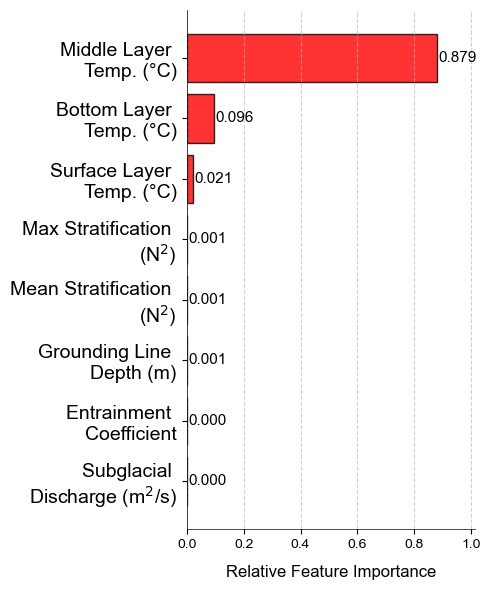

In [ ]:
ds_surface = ds.where(ds.surfaced == True, drop=True)

# Function to prepare data
def prepare_data(ds):
    X = ds_surface[['Q0', 'alpha', 'z_max', 'bottom_third_temp', 'middle_third_temp', 'top_third_temp', 'stratification_mean', 'stratification_max']].to_array().T

    # y_temperature = ds_surface['temperature_profile'].isel(depth=0).values  # assuming the top value is the surface
    # select the surface temperature (mean of last 5 meters)
    # y_temperature = ds_surface.temperature_profile.isel(depth=0).values
    y_temperature = ds_surface.temperature_profile.isel(depth=-17).values.flatten()

    # check for NaN values in y_temperature
    if np.isnan(y_temperature).any():
        print("Warning: NaN values found in y_temperature.")
    # print the number of NaN values
    print(f"Number of NaN values in y_temperature: {np.isnan(y_temperature).sum()}")

    # remove NaN values from X and y_temperature
    mask = ~np.isnan(y_temperature)
    X = X[mask]
    y_temperature = y_temperature[mask]

    return X, y_temperature

# Prepare data
print('prepping data')
X, y_temperature = prepare_data(ds)

# Split data for the temperature model
print('splitting data')
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y_temperature, test_size=0.2, random_state=0)

# Train Random Forest for temperature
print('training model')
rf_temperature = RandomForestRegressor(n_estimators=100, random_state=0)
rf_temperature.fit(X_train, y_train_temp)

# Define feature name mapping to publication-ready names
feature_name_map = {
    'Q0': 'Subglacial \nDischarge (m$^2$/s)',
    'alpha': 'Entrainment \nCoefficient',
    'z_max': 'Grounding Line \nDepth (m)',
    'bottom_third_temp': 'Bottom Layer \nTemp. (°C)',
    'middle_third_temp': 'Middle Layer \nTemp. (°C)',
    'top_third_temp': 'Surface Layer \nTemp. (°C)',
    'stratification_mean': 'Mean Stratification \n(N$^2$)',
    'stratification_max': 'Max Stratification \n(N$^2$)'
}

# Sort features by importance for better visualization
sorted_idx = np.argsort(rf_temperature.feature_importances_)
sorted_importances = rf_temperature.feature_importances_[sorted_idx]
sorted_features = np.array([feature_name_map[key] for key in ['Q0', 'alpha', 'z_max', 'bottom_third_temp', 
                                                              'middle_third_temp', 'top_third_temp', 'stratification_mean', 'stratification_max']])[sorted_idx]

import matplotlib.font_manager as fm

plt.figure(figsize=(5, 6))
bars = plt.barh(range(len(sorted_importances)), sorted_importances, 
                align='center', color='red', alpha=0.8, edgecolor='k')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontsize=11)

# Formatting
plt.yticks(range(len(sorted_importances)), sorted_features, fontsize=14)
plt.xlabel('Relative Feature Importance', fontsize=12, labelpad=10)


# Grid and spines
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# Adjust layout
plt.xlim(0, max(sorted_importances) * 1.15)  # Add space for labels
plt.tight_layout()

plt.savefig('feature_importance_temp2.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

Text(0.01, 0.99, 'b')

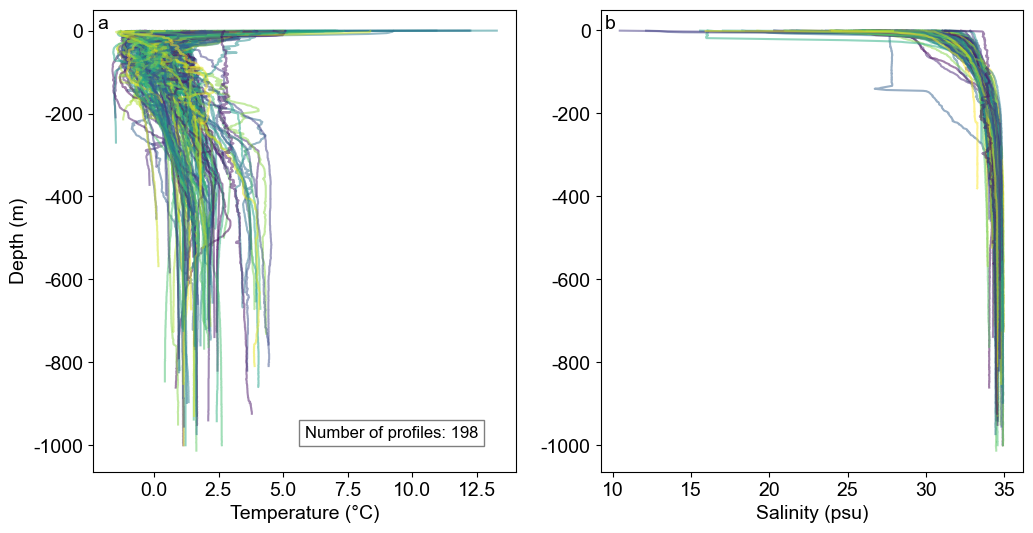

In [ ]:
# load the dataset from the NetCDF file
combined_omg_ctd_ds = xr.open_dataset('C:/Users/s1834371/OneDrive - University of Edinburgh/data/CTD_data/OMG_AXCTD/OMG_AXCTD_CTD_combined_reduced.nc')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.rcParams.update({'font.size': 14})
colormap = plt.get_cmap('viridis', len(combined_omg_ctd_ds.profile))  
colors = [colormap(i) for i in range(len(combined_omg_ctd_ds.profile))]
colors = np.random.permutation(colors)
for idx, profile in enumerate(combined_omg_ctd_ds.profile):
    axs[0].plot(
        combined_omg_ctd_ds['temperature'].sel(profile=profile),
        combined_omg_ctd_ds['depth'].sel(profile=profile) * -1,
        label=f'Profile {profile.values}', color=colors[idx], alpha=0.5)
    axs[1].plot(
        combined_omg_ctd_ds['salinity'].sel(profile=profile),
        combined_omg_ctd_ds['depth'].sel(profile=profile) * -1,
        label=f'Profile {profile.values}', color=colors[idx], alpha=0.5)
    
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Depth (m)')
axs[1].set_xlabel('Salinity (psu)')
# axs[1].invert_yaxis()  # Invert y-axis for depth
# axs[0].invert_yaxis()  # Invert y-axis for depth

# add text box of number of profiles
axs[0].text(0.5, 0.1, f'Number of profiles: {len(combined_omg_ctd_ds.profile)}', transform=axs[0].transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.5))
axs[0].text(0.01, 0.99, 'a', transform=axs[0].transAxes,
            fontsize=14, verticalalignment='top', horizontalalignment='left')
axs[1].text(0.01, 0.99, 'b', transform=axs[1].transAxes,
            fontsize=14, verticalalignment='top', horizontalalignment='left')

Text(0, 0.5, 'Depth (m)')

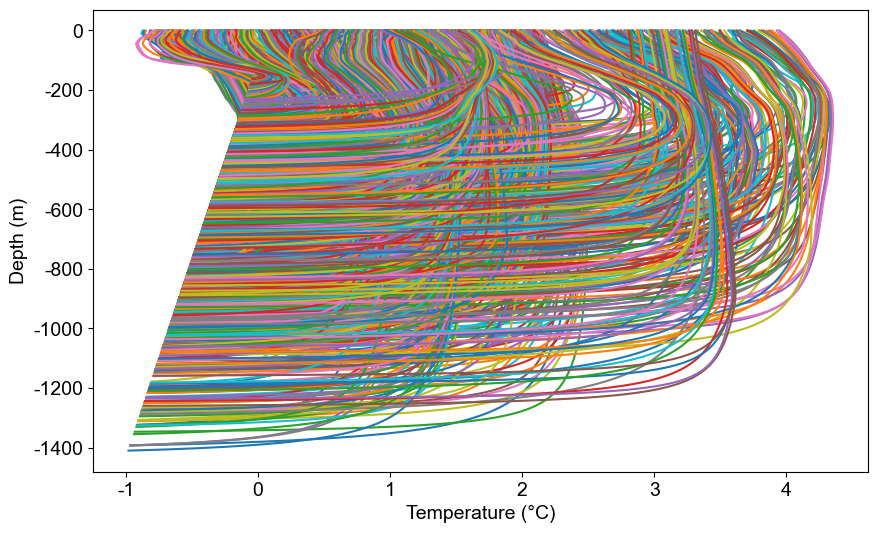

In [ ]:
plt.figure(figsize=(10, 6))

for i in range(len(ds_surface.depth_profile)):
    plt.plot(ds_surface.temperature_profile.isel(profile=i), ds_surface.depth_profile.isel(profile=i), label=f'Profile {i}')
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')